In [1]:
#Hyperparameters
categories=['yes','no','up','down','left','right','on','off','stop','go']
#categories=['yes','no','up','down','left','right','on','off','stop','go','zero','one','two','three','four','five','six','seven','eight','nine','unknown']
nCategories=len(categories)
print(nCategories)

nTrainSamples=30000 #30k, 84k
nValidSamples=3000 #3k, 9900
nTestSamples=3000 #3k, 11k



10


# 1) Prepare X_train, X_val, y_train, y_val

In [2]:
import LoadAndPreprocessDataset

In [3]:
#Load filenames
train,val,test = LoadAndPreprocessDataset.loadDatasetFilenames(nCategories=nCategories)

#Load TRAIN files
X,y_train=LoadAndPreprocessDataset.loadBatch(train,batch_size=nTrainSamples, nCategories=nCategories)
#Preprocess TRAIN
X_train=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_train=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#X_train=LoadAndPreprocessDataset.melspect(X)
#X_train=X #No preprocessing
#Release memory
del(X)

#Load VAL files
X,y_val=LoadAndPreprocessDataset.loadBatch(val,batch_size=nValidSamples, nCategories=nCategories)
#Preprocess VAL
X_val=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_val=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#X_val=LoadAndPreprocessDataset.melspect(X)
#X_val=X #No preprocessing
#Release memory
del(X)

print(X_train.shape,X_val.shape)


# NORMALIZATION
### NO normalization seems better
#from sklearn.preprocessing import normalize
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1,1)) # Gives huge bias
#for i in range(len(X_train)):
    #X_train[i]=normalize(X_train[i], axis=0, norm='max') #normalize each feature of the example
    #X_train[i]=(X_train[i] - X_train[i].min(0)) / X_train[i].ptp(0) # HUGE BIAS
    #X_train[i]=scaler.fit_transform(X_train[i]) # HUGE BIAS
#for i in range(len(X_val)):
    #X_val[i]=normalize(X_val[i], axis=0, norm='max') #normalize each feature of the example
    #X_val[i]=(X_val[i] - X_val[i].min(0)) / X_val[i].ptp(0) #HUGE BIAS
    #X_val[i]=scaler.fit_transform(X_val[i])  # HUGE BIAS


#ADD extra dimension for CNN
import numpy as np
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
print(X_train.shape,X_val.shape)


print('X_train uses',X_train.shape[0],"of",len(train),"files","and occupies",X_train.nbytes,"bytes")
print('X_val uses',X_val.shape[0],"of",len(val),"files","and occupies",X_val.nbytes,"bytes")

(30000, 120, 126) (3000, 120, 126)
(30000, 120, 126, 1) (3000, 120, 126, 1)
X_train uses 30000 of 30769 files and occupies 3628800000 bytes
X_val uses 3000 of 3703 files and occupies 362880000 bytes


In [4]:
#DEBUGGING: Check how many examples there are per category
trainCat={}
for e in categories: trainCat[e]=0
for e in y_train: trainCat[categories[e]]+=1
print(trainCat)

valCat={}
for e in categories: valCat[e]=0
for e in y_val: valCat[categories[e]]+=1
print(valCat)

{'yes': 3163, 'no': 3032, 'up': 2870, 'down': 3059, 'left': 2959, 'right': 2944, 'on': 2997, 'off': 2900, 'stop': 3045, 'go': 3031}
{'yes': 319, 'no': 335, 'up': 276, 'down': 311, 'left': 282, 'right': 287, 'on': 295, 'off': 304, 'stop': 288, 'go': 303}


(30000, 120, 126, 1)
(30000,)
(3000, 120, 126, 1)
(3000,)


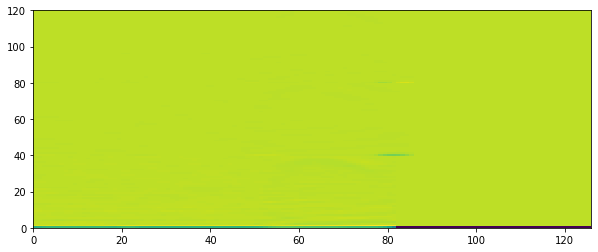

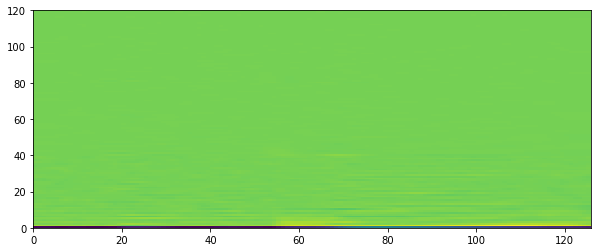

-715.541748046875
156.43775939941406


In [5]:
# Look at some data

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.pcolormesh(X_train[0,:,:,0])
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(X_val[0,:,:,0])
plt.show()

import numpy as np
print(np.min(X_train))
print(np.max(X_train))


----------------------------------------------------

# 2) Model


## Define NN

In [6]:
import Models

In [7]:
import datetime

modelName="DSConvModel"+str(nCategories)
save_name=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_"+modelName

'''model = Models.LeNet5(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)
model = Models.AttRNNSpeechModel(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)
Xmodel = Models.directCNN(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)'''


################### DA FARE I SEGUENTI #####################
model = Models.DSConvModel(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)

'''model = Models.DSConvModelMedium(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)'''

'''model = Models.DSConvModelSmall(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)'''
############################################################


model.compile(optimizer='nadam',
              loss=['sparse_categorical_crossentropy'],
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "DSConvModel10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 63, 276)      11316     
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 63, 276)      1104      
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 59, 31, 276)       2760      
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 31, 276)       1104      
_________________________________________________________________
activation (Activation)      (None, 59, 31, 276)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 31, 276)     

## Train NN

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
import math


log_dir = "logs\\"+save_name

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

def performance_scheduling(epoch):
    #.....
    return lrate

my_callbacks = [
    EarlyStopping(monitor='val_sparse_categorical_accuracy',
                  patience=10,
                  verbose=1,
                  restore_best_weights=True),
    ModelCheckpoint('models/'+save_name+'.h5',
                    monitor='val_sparse_categorical_accuracy',
                    verbose=1,
                    save_best_only=True),
    TensorBoard(log_dir=log_dir,histogram_freq=1)]
    #lrate]


In [9]:
#Train
results = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val,y_val),
                    batch_size=32, # usually between 10 and 32
                    epochs=50,
                    callbacks=my_callbacks,
                    verbose=1)

#model.save('models/'+modelName+'.h5')

Train on 30000 samples, validate on 3000 samples
Epoch 1/50
29984/30000 [============================>.] - ETA: 0s - loss: 0.8556 - sparse_categorical_accuracy: 0.7711
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.73533, saving model to models/2020-08-02_13-30_DSConvModel10.h5
30000/30000 [==============================] - 304s 10ms/sample - loss: 0.8553 - sparse_categorical_accuracy: 0.7711 - val_loss: 0.9339 - val_sparse_categorical_accuracy: 0.7353
Epoch 2/50
29984/30000 [============================>.] - ETA: 0s - loss: 0.2692 - sparse_categorical_accuracy: 0.9116
Epoch 00002: val_sparse_categorical_accuracy improved from 0.73533 to 0.89367, saving model to models/2020-08-02_13-30_DSConvModel10.h5
30000/30000 [==============================] - 279s 9ms/sample - loss: 0.2691 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.3487 - val_sparse_categorical_accuracy: 0.8937
Epoch 3/50
29984/30000 [============================>.] - ETA: 0s - loss: 0.1977 - sparse

Epoch 22/50
29984/30000 [============================>.] - ETA: 0s - loss: 0.0213 - sparse_categorical_accuracy: 0.9934
Epoch 00022: val_sparse_categorical_accuracy did not improve from 0.94600
30000/30000 [==============================] - 286s 10ms/sample - loss: 0.0213 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.3207 - val_sparse_categorical_accuracy: 0.9373
Epoch 23/50
29984/30000 [============================>.] - ETA: 0s - loss: 0.0226 - sparse_categorical_accuracy: 0.9930
Epoch 00023: val_sparse_categorical_accuracy did not improve from 0.94600
30000/30000 [==============================] - 290s 10ms/sample - loss: 0.0226 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.3098 - val_sparse_categorical_accuracy: 0.9420
Epoch 24/50
29984/30000 [============================>.] - ETA: 0s - loss: 0.0224 - sparse_categorical_accuracy: 0.9933Restoring model weights from the end of the best epoch.

Epoch 00024: val_sparse_categorical_accuracy did not improve from 0.94600
30000/

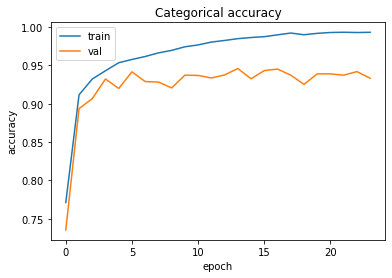

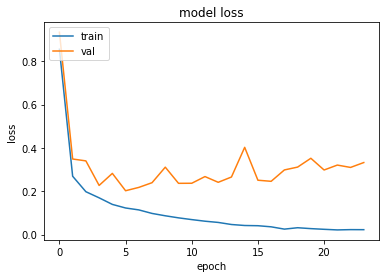

In [10]:
import matplotlib.pyplot as plt

save_dir="output/"+save_name+"_"

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Categorical Accuracy", dpi=400)
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Loss", dpi=400)
plt.show()



--------------------------------------------

# 3) Test the model

In [11]:
#Release memory
del(X_train)
del(y_train)
del(X_val)
del(y_val)

In [12]:
#Load TEST file
X,y_test=LoadAndPreprocessDataset.loadBatch(test,batch_size=nTestSamples, nCategories=nCategories)
#Preprocess TEST
X_test=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_test=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
#X_test=LoadAndPreprocessDataset.melspect(X)
#X_test=X
#Release memory
del(X)

#ADD extra dimension for CNN
import numpy as np
X_test = X_test[..., np.newaxis]


print('X_test uses',X_test.shape[0],"of",len(test),"files","and occupies",X_test.nbytes,"bytes")


#DEBUGGING: Check how many examples there are per category
testCat={}
for e in categories: testCat[e]=0
for e in y_test: testCat[categories[e]]+=1
print(testCat)

X_test uses 3000 of 4074 files and occupies 362880000 bytes
{'yes': 307, 'no': 294, 'up': 313, 'down': 304, 'left': 284, 'right': 299, 'on': 310, 'off': 293, 'stop': 298, 'go': 298}


In [13]:
#load best model
from tensorflow.keras.models import load_model
model = load_model('models/'+save_name+'.h5')

# Test the model on test data
import numpy as np
score = model.evaluate(X_test, y_test)
y_pred=np.argmax(model.predict(X_test),1)


#Measure time for every single prediction
"""import time

s=time.time()
y_pred=np.argmax(model.predict(X_test[:500,:,:]),1)
e=time.time()
print("Entire:",e-s)

starts=np.empty((len(X_test),))
ends=np.empty((len(X_test),))
for i in range(len(X_test)):
    a=np.array([X_test[i]])
    starts[i]=time.time()
    a=np.argmax(model.predict(a),1)
    ends[i]=time.time()
average=sum(ends-starts)/len(X_test)
print("Average single prediction time (s):",average)"""

# 1 prediction or a batch of 10 requires the same amount of time
# a batch of 100 prediction requires the double of 1
# a batch of 500 prediction requires the 3 times of 1

3000/3000 [==============================] - 7s 2ms/sample - loss: 0.2569 - sparse_categorical_accuracy: 0.9393


'import time\n\ns=time.time()\ny_pred=np.argmax(model.predict(X_test[:500,:,:]),1)\ne=time.time()\nprint("Entire:",e-s)\n\nstarts=np.empty((len(X_test),))\nends=np.empty((len(X_test),))\nfor i in range(len(X_test)):\n    a=np.array([X_test[i]])\n    starts[i]=time.time()\n    a=np.argmax(model.predict(a),1)\n    ends[i]=time.time()\naverage=sum(ends-starts)/len(X_test)\nprint("Average single prediction time (s):",average)'

# 4) Metrics Summary

Train loss:	 0.022
Train accuracy:	 0.993
Val loss:	 0.332
Val accuracy:	 0.933
Test loss:	 0.257
Test accuracy:	 0.939
Bias:		 0.007
Variance:	 0.06
Precision:	 0.939
Recall:		 0.939
F1:		 0.939


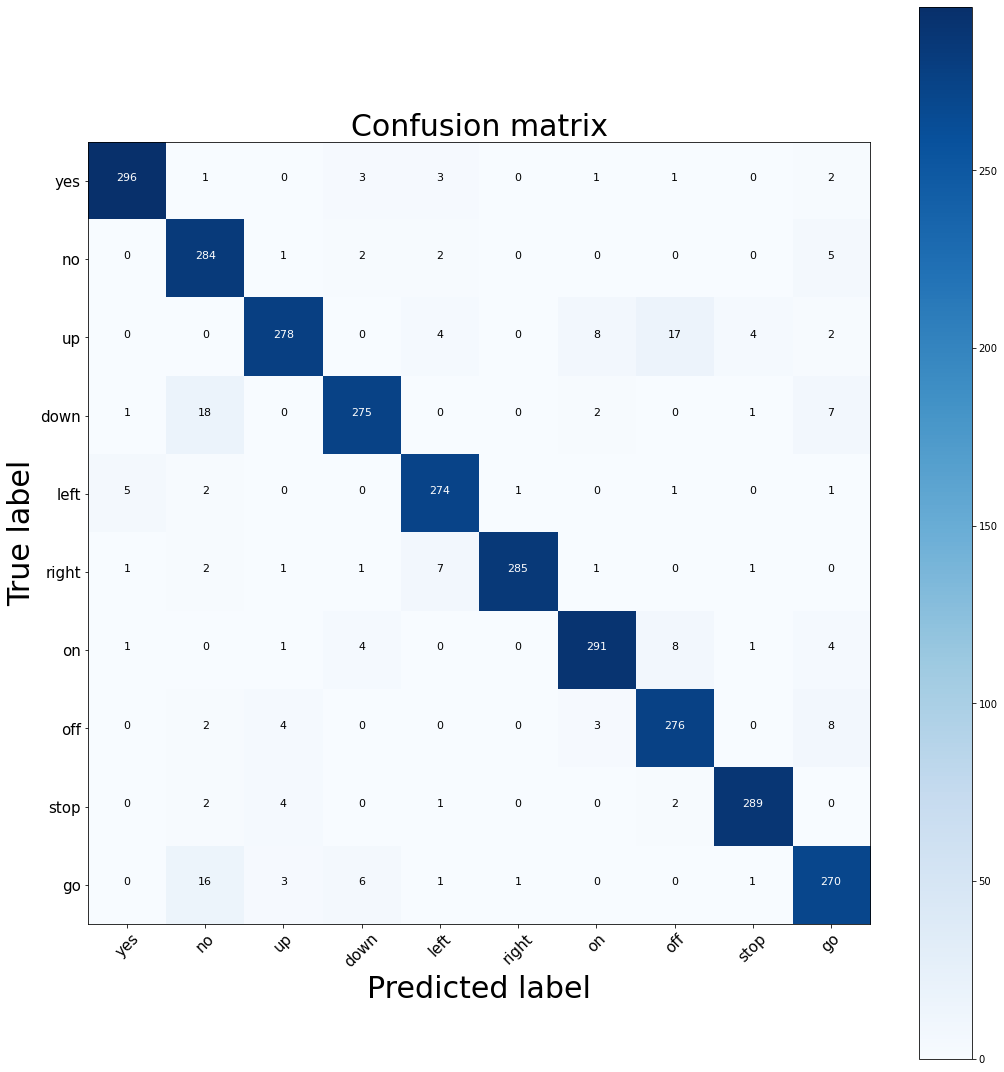

In [14]:
train_loss=results.history.get('loss')[-1]
val_loss=results.history.get('val_loss')[-1]

train_error=1-results.history.get('sparse_categorical_accuracy')[-1]
val_error=1-results.history.get('val_sparse_categorical_accuracy')[-1]

test_loss=score[0]
test_error=1-score[1]

print('Train loss:\t', round(train_loss,3))
print('Train accuracy:\t', round(1-train_error,3))
print('Val loss:\t', round(val_loss,3))
print('Val accuracy:\t', round(1-val_error,3))
print('Test loss:\t', round(test_loss,3))
print('Test accuracy:\t', round(score[1],3))

optimal_error=0.00 #human error

bias=train_error-optimal_error
variance=val_error-train_error
print("Bias:\t\t",round(bias,3))
print("Variance:\t",round(variance,3))


# Precision and Recall(sensitivity/true positive rate)
from sklearn.metrics import precision_score, recall_score
prec=precision_score(y_test, y_pred,average='micro')
rec=recall_score(y_test, y_pred,average='micro')

#F1 - high if both recall and precision are high.
from sklearn.metrics import f1_score
f1=f1_score(y_test, y_pred,average='micro')

print("Precision:\t",round(prec,3))
print("Recall:\t\t",round(rec,3))
print("F1:\t\t",round(f1,3))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
import audioUtils
audioUtils.plot_confusion_matrix(cm,categories, normalize=False,save_path=save_dir)



# SAVE MODEL SUMMARY and METRICS TO FILE
f = open(save_dir+"Metrics.txt", "a")

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
f.write(short_model_summary+"\n\n")

f.write('Train loss:\t'+ str(round(train_loss,3))+ "\n")
f.write('Train accuracy:\t'+ str((round(1-train_error,3)))+ "\n")
f.write('Val loss:\t'+ str(round(val_loss,3))+ "\n")
f.write('Val accuracy:\t'+ str((round(1-val_error,3)))+ "\n")
f.write('Test loss:\t'+ str(round(test_loss,3))+ "\n")
f.write('Test accuracy:\t'+ str(round(score[1],3))+ "\n")
f.write("Bias:\t\t"+str(round(bias,3))+ "\n")
f.write("Variance:\t"+str(round(variance,3))+ "\n")
f.write("Precision:\t"+str(round(prec,3))+ "\n")
f.write("Recall:\t\t"+str(round(rec,3))+ "\n")
f.write("F1:\t\t"+str(round(f1,3)))
f.close()

In [15]:
#Most mispredicted words
n_mistakes=20
import heapq
h=[]
for i in range(nCategories):
    for j in range(i+1,nCategories):
        heapq.heappush(h,(cm[i,j]+cm[j,i],(i,j)))
for e in heapq.nlargest(n_mistakes,h):
    print(e[0],categories[e[1][0]],"-",categories[e[1][1]])
    
f = open(save_dir+"Metrics.txt", "a")
f.write('\n\nMost '+str(n_mistakes)+ ' mispredicted words\n')
for e in heapq.nlargest(n_mistakes,h):
    f.write(str(e[0])+"\t"+str(categories[e[1][0]])+"-"+str(categories[e[1][1]])+"\n")
f.close()

21 up - off
21 no - go
20 no - down
13 down - go
11 on - off
9 up - on
8 off - go
8 left - right
8 up - stop
8 yes - left
6 down - on
5 up - go
4 on - go
4 up - left
4 no - left
4 yes - down
2 off - stop
2 left - go
2 no - stop
2 no - off
